# 🏥 Medicine AI Suite (All-in-One)

**Project Title:** Medicine Sales Prediction using Disease Outbreak Patterns  
**Author:** Shanmukha Sri Saikumar Medisetty  

**Tech Stack:** Python, Pandas, NumPy, Scikit-learn, Streamlit  
**Optional Modules:** SARIMA (statsmodels), SHAP, PyTrends, Transformers (BERT)

**Dataset Files:**
- `data/disease_cases.csv`
- `data/medicine_sales.csv`

---

## 📋 Table of Contents
1. Problem Definition & Objective  
2. Data Understanding & Preparation  
3. Exploratory Data Analysis (EDA)  
4. Model / System Design  
5. Core Implementation  
6. Evaluation & Analysis  
7. Ethical Considerations & Responsible AI  
8. Conclusion & Future Scope

## 1️⃣ Problem Definition & Objective

### ✅ Problem Statement
During disease outbreaks, medicine demand rises rapidly. Pharmacies and hospitals require an AI system to predict sales demand so they can optimize inventory and reduce shortages.

### ✅ Objective
Predict **medicine sales volume (`sales_volume`)** from disease patterns (`cases`, `disease_trend`) across locations and time.

### ✅ Motivation
- Better inventory planning  
- Faster supply-chain response  
- Reduced medicine wastage

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

## 2️⃣ Data Understanding & Preparation
We load 2 datasets and merge them using:

- `date`
- `location`

Then we create:
- `month`, `year`
- `disease_trend` = pct_change(cases) grouped by location

In [12]:
import pandas as pd
from pathlib import Path

data_dir = Path("data")

disease_path = data_dir / "disease_cases.csv"
sales_path   = data_dir / "medicine_sales.csv"

print("✅ Looking for:", disease_path)
print("✅ Looking for:", sales_path)

assert disease_path.exists(), f"❌ Missing: {disease_path}"
assert sales_path.exists(), f"❌ Missing: {sales_path}"

disease_df = pd.read_csv(disease_path)
sales_df   = pd.read_csv(sales_path)

print("✅ Loaded:", disease_df.shape, sales_df.shape)


✅ Looking for: data\disease_cases.csv
✅ Looking for: data\medicine_sales.csv
✅ Loaded: (9054, 4) (10104, 4)


In [14]:
import pandas as pd
from pathlib import Path

# paths
disease_path = Path("data/disease_cases.csv")
sales_path   = Path("data/medicine_sales.csv")

# load
disease_df = pd.read_csv(disease_path)
sales_df   = pd.read_csv(sales_path)

# drop unwanted column
for d in [disease_df, sales_df]:
    if "Unnamed: 0" in d.columns:
        d.drop(columns=["Unnamed: 0"], inplace=True)

# datetime
disease_df["date"] = pd.to_datetime(disease_df["date"], errors="coerce")
sales_df["date"]   = pd.to_datetime(sales_df["date"], errors="coerce")

# ✅ merge
df = pd.merge(disease_df, sales_df, on=["date", "location"], how="inner")

# features
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df["disease_trend"] = df.groupby("location")["cases"].pct_change().fillna(0)

df.head()


,date,location,cases,disease_type,sales_volume,medicine,month,year,disease_trend
0,2005-01-01,Hyderabad,149,Dengue,50,Paracetamol,1,2005,0.0
1,2005-01-01,Hyderabad,149,Dengue,117,ORS,1,2005,0.0
2,2005-01-01,Hyderabad,149,Dengue,177,Antibiotics,1,2005,0.0
3,2005-01-01,Hyderabad,149,Dengue,186,Chloroquine,1,2005,0.0
4,2005-01-01,Hyderabad,149,Dengue,22,Antibiotics,1,2005,0.0


In [15]:
print("✅ Merged dataset shape:", df.shape)
print("✅ Columns:", df.columns.tolist())
df.info()

✅ Merged dataset shape: (45403, 9)
✅ Columns: ['date', 'location', 'cases', 'disease_type', 'sales_volume', 'medicine', 'month', 'year', 'disease_trend']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45403 entries, 0 to 45402
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           45403 non-null  datetime64[ns]
 1   location       45403 non-null  object        
 2   cases          45403 non-null  int64         
 3   disease_type   45403 non-null  object        
 4   sales_volume   45403 non-null  int64         
 5   medicine       45403 non-null  object        
 6   month          45403 non-null  int32         
 7   year           45403 non-null  int32         
 8   disease_trend  45403 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(2), int64(2), object(3)
memory usage: 2.8+ MB


## 3️⃣ Exploratory Data Analysis (EDA)
We explore:
- Missing values
- Distributions
- Year-wise trends
- Correlation

In [16]:
# Missing values
df.isnull().sum()

date             0
location         0
cases            0
disease_type     0
sales_volume     0
medicine         0
month            0
year             0
disease_trend    0
dtype: int64

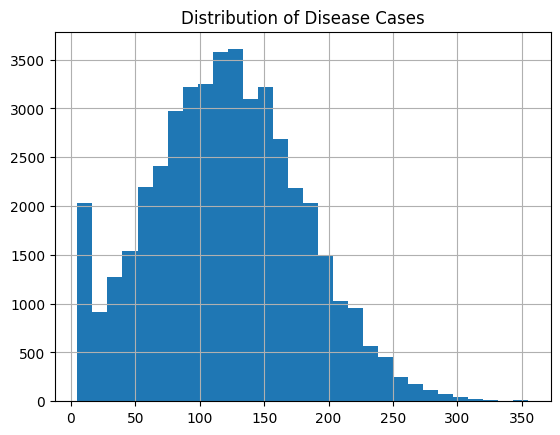

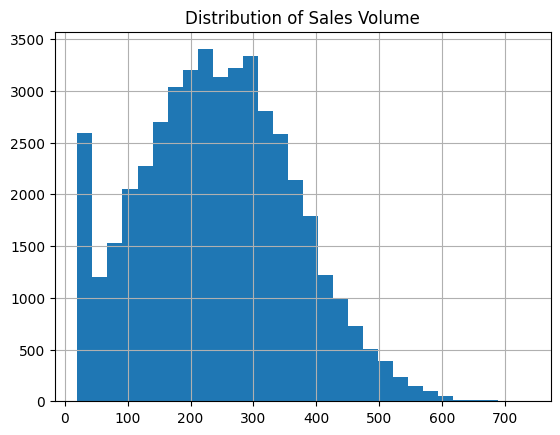

In [17]:
# Distributions
df["cases"].hist(bins=30)
plt.title("Distribution of Disease Cases")
plt.show()

df["sales_volume"].hist(bins=30)
plt.title("Distribution of Sales Volume")
plt.show()

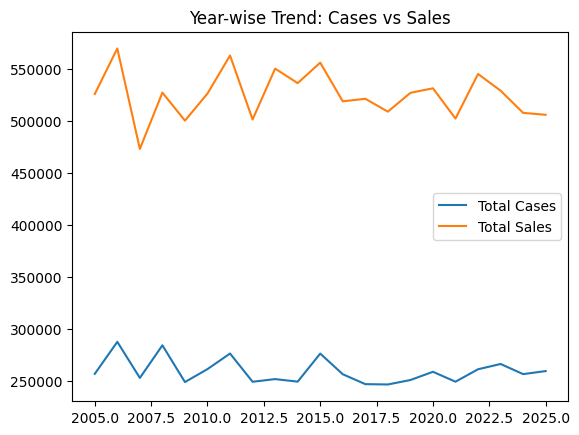

,year,cases,sales_volume
0,2005,257162,525863
1,2006,287901,569580
2,2007,253265,473114
3,2008,284573,527232
4,2009,249304,500294


In [18]:
# Year-wise trend
yearly = df.groupby("year")[["cases", "sales_volume"]].sum().reset_index()

plt.plot(yearly["year"], yearly["cases"], label="Total Cases")
plt.plot(yearly["year"], yearly["sales_volume"], label="Total Sales")
plt.legend()
plt.title("Year-wise Trend: Cases vs Sales")
plt.show()

yearly.head()

In [19]:
# Correlation matrix
df[["cases", "disease_trend", "month", "year", "sales_volume"]].corr()

,cases,disease_trend,month,year,sales_volume
cases,1.000000,0.092502,-0.013608,-0.006780,-0.007868
disease_trend,0.092502,1.000000,-0.001251,0.005889,0.005921
month,-0.013608,-0.001251,1.000000,0.011138,0.096844
year,-0.006780,0.005889,0.011138,1.000000,0.009059
sales_volume,-0.007868,0.005921,0.096844,0.009059,1.000000


## 4️⃣ Model / System Design

### ML Modules Included
- Regression: **Linear Regression / Random Forest**
- Classification: **Logistic Regression** (Sales Risk: Low/Medium/High)
- Clustering: **KMeans / DBSCAN**
- Anomaly Detection: **Isolation Forest**

### Features
- cases
- disease_trend
- month
- year
- location_encoded

### Target
- sales_volume

## 5️⃣ Core Implementation (OOP Model Pipeline)

We use your project class:
- `src/model.py` → `MedicineSalesModel`

In [20]:
import sys
from pathlib import Path

# make sure root folder is added
sys.path.insert(0, str(Path(".")))

from src.model import MedicineSalesModel

### ✅ Regression (Sales Prediction)

In [21]:
reg_model = MedicineSalesModel(model_type="rf")
stats_reg = reg_model.train_regression(df)
stats_reg

{'model': 'rf',
 'train_r2': 0.461,
 'test_r2': -0.12,
 'features': ['cases', 'disease_trend', 'month', 'year', 'location_encoded']}

In [ ]:
sample = df.sample(5)[["cases", "disease_trend", "month", "year", "location"]]
preds = reg_model.predict_regression(sample)

out = sample.copy()
out["predicted_sales_volume"] = preds
out

### ✅ Classification (Sales Risk)
Risk classes are created using quantiles of sales volume:

- 0 = Low  
- 1 = Medium  
- 2 = High

In [24]:
cls_model = MedicineSalesModel(model_type="logistic")
stats_cls = cls_model.train_classification(df)
stats_cls

{'model': 'logistic',
 'accuracy': 0.385,
 'features': ['cases', 'disease_trend', 'month', 'year', 'location_encoded']}

In [23]:
sample_cls = df.sample(5)[["cases", "disease_trend", "month", "year", "location"]]
risk_preds = cls_model.predict_classification(sample_cls)

risk_map = {0: "LOW", 1: "MEDIUM", 2: "HIGH"}

res_cls = sample_cls.copy()
res_cls["predicted_risk"] = [risk_map[int(x)] for x in risk_preds]
res_cls

,cases,disease_trend,month,year,location,predicted_risk
34277,31,0.0,10,2020,Kurnool,HIGH
40257,219,0.0,7,2023,Nellore,HIGH
39474,124,0.0,3,2023,Rajahmundry,LOW
24514,125,24.0,3,2016,Tirupati,MEDIUM
13421,65,0.0,2,2011,Nellore,LOW


### ✅ Clustering (KMeans)

In [25]:
clust_model = MedicineSalesModel(model_type="kmeans")
labels = clust_model.fit_clustering(df)

df_cluster = df.copy()
df_cluster["cluster"] = labels

df_cluster["cluster"].value_counts()

cluster
1    20458
2    13335
0    11610
Name: count, dtype: int64

### ✅ Anomaly Detection (Isolation Forest)

In [26]:
anom_model = MedicineSalesModel(model_type="isolation")
anom_model.anomaly_detector.set_params(contamination=0.02)

anom_labels = anom_model.fit_anomaly(df)

df_anom = df.copy()
df_anom["anomaly"] = anom_labels

df_anom[df_anom["anomaly"] == -1].head(20)

,date,location,cases,disease_type,sales_volume,medicine,month,year,disease_trend,anomaly
33,2005-01-01,Visakhapatnam,214,Dengue,155,Chloroquine,1,2005,0.000000,-1
34,2005-01-01,Visakhapatnam,214,Dengue,92,Antibiotics,1,2005,0.000000,-1
35,2005-01-01,Visakhapatnam,214,Dengue,328,Paracetamol,1,2005,0.000000,-1
36,2005-01-01,Visakhapatnam,214,Dengue,439,Vitamin C,1,2005,0.000000,-1
37,2005-01-01,Visakhapatnam,214,Dengue,286,ORS,1,2005,0.000000,-1
38,2005-01-01,Visakhapatnam,214,Dengue,310,ORS,1,2005,0.000000,-1
39,2005-01-01,Visakhapatnam,214,Dengue,137,ORS,1,2005,0.000000,-1
40,2005-01-01,Visakhapatnam,166,Dengue,155,Chloroquine,1,2005,-0.224299,-1
47,2005-01-01,Visakhapatnam,91,Malaria,155,Chloroquine,1,2005,-0.451807,-1
81,2005-01-01,Tirupati,5,Flu,20,Antibiotics,1,2005,-0.962687,-1


## 6️⃣ Evaluation & Analysis

We evaluate:
- Regression → Train/Test R²
- Classification → Accuracy
- Clustering → Distribution of clusters
- Anomaly detection → Number of anomalies found

In [27]:
print("✅ Regression:", stats_reg)
print("✅ Classification:", stats_cls)
print("✅ Cluster Distribution:", df_cluster["cluster"].value_counts().to_dict())
print("✅ Anomalies Found:", int((df_anom["anomaly"] == -1).sum()))

✅ Regression: {'model': 'rf', 'train_r2': 0.461, 'test_r2': -0.12, 'features': ['cases', 'disease_trend', 'month', 'year', 'location_encoded']}
✅ Classification: {'model': 'logistic', 'accuracy': 0.385, 'features': ['cases', 'disease_trend', 'month', 'year', 'location_encoded']}
✅ Cluster Distribution: {1: 20458, 2: 13335, 0: 11610}
✅ Anomalies Found: 909


## 7️⃣ Ethical Considerations & Responsible AI
- Dataset may be limited to only certain regions/years (bias risk)
- Model is trained on historical patterns and may fail during new outbreak scenarios
- This is an **academic prototype** and should not be used directly for clinical decisions

## 8️⃣ Conclusion & Future Scope

### ✅ Conclusion
The project successfully builds a complete AI pipeline for predicting medicine sales volume using outbreak patterns, supported by a Streamlit dashboard.

### 🚀 Future Scope
- Add deep learning forecasting models (LSTM/Transformer)
- Add external signals (weather, population, hospital stock)
- Improve deployment using Streamlit Cloud